In [174]:
import pandas as pd
import json
import urllib.request, urllib.error, urllib.parse
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from bs4 import BeautifulSoup 
import urllib.request 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore")

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['the','4',".","me.","many","the..."]
stopwords.extend(newStopWords)



data = pd.read_csv("Campus Academic Management Survey.csv")

part1 = data.iloc[:,1:13]
part2 = data.iloc[:,13:20]
part3 = data.iloc[:,20:30]

In [72]:
def eText(question):
    text = ""
    for q in question.dropna():
        text = text + str(q) + "  "
    while '  ' in text:
        text = text.replace('  ', '. ')
    while '..' in text:
        text = text.replace('..', '.')
        
    
    return(text)

In [121]:
def QuanQuestions():
    questions = part1.columns
    part1Report = pd.DataFrame(questions, columns=["Question"])
    for res in responses:
        part1Report[res] = 0
    for qu in questions:
        for res in responses:
            part1Report[res][part1Report["Question"]==qu] = len(part1[part1[qu]==res])

    part1Report["Total"] = part1Report[responses[0]] + part1Report[responses[1]] + part1Report[responses[2]]

    for i in range(len(questions)):
        plt.figure();
        r1 = part1Report.iloc[i:i+1,:]
        r2 = r1.T
        r2 = r2.iloc[1:4,:]
        r2.columns = ['Response']
        r2["Response"].plot.pie(title=r1["Question"].iloc[:1].to_string() , labels=['Academic', 'Joint', 'Campus'], autopct='%.2f', fontsize=20, figsize=(6, 6))
        plt.savefig('WorldCloud.png', bbox_inches='tight')
        document.add_picture('WorldCloud.png', width=Inches(3))

In [22]:

def QSentiment():
    data = pd.read_csv("Campus Academic Management Survey.csv")
    data = data.iloc[:,20:30]
    cols = data.columns
    Report = pd.DataFrame(cols,columns=["Question"])


    APPLICATION_ID = "13ea824b"
    APPLICATION_KEY = "7a81e3feb66047de3fd85e16f7b46434"

    def call_api(endpoint, parameters):
      url = 'https://api.aylien.com/api/v1/' + endpoint
      headers = {
          "Accept":                             "application/json",
          "Content-type":                       "application/x-www-form-urlencoded",
          "X-AYLIEN-TextAPI-Application-ID":    APPLICATION_ID,
          "X-AYLIEN-TextAPI-Application-Key":   APPLICATION_KEY
      }
      opener = urllib.request.build_opener()
      request = urllib.request.Request(url,
        urllib.parse.urlencode(parameters).encode('utf-8'), headers)
      response = opener.open(request);
      return json.loads(response.read().decode())

    Report["Sentiment"] = ""
    Report["Keywords"] = ""

    for cls in cols:
        parameters = {"text": eText(data[cls])}
        sentiment = call_api("sentiment", parameters)
        Report["Sentiment"][Report["Question"]==cls] = (sentiment["polarity"])
        entities = call_api("entities", parameters)
        allent = entities["entities"]["keyword"]
        nellent = ', '.join(map(str, allent))
        Report["Keywords"][Report["Question"]==cls] = nellent

    qu = Report["Question"]

    table = document.add_table(rows=1, cols=3)
    hdr_cells = table.rows[0].cells
    hdr_cells[0].text = 'Question'
    hdr_cells[1].text = 'Sentiment'
    hdr_cells[2].text = 'Keywords'
    for q in qu:

        r = Report[Report["Question"] == q]
        row_cells = table.add_row().cells
        row_cells[0].text = r["Question"].to_string()
        row_cells[1].text = r["Sentiment"].to_string()
        row_cells[2].text = r["Keywords"].to_string()
    
    writer = pd.ExcelWriter('output.xlsx')
    Report.to_excel(writer,'Sheet1')
    writer.save()

In [175]:
#stopWords = set(stopwords.words("english"))
writer = pd.ExcelWriter('OpenEnded.xlsx')

questions = part3.columns
stat = []

st = pd.DataFrame(questions, columns=["Question"])

st["Avergae"] = 0
st["Median"] = 0
st["Std"] = 0


i = 0
for q in questions:

    text = eText(part3[q])
    words = word_tokenize(text)

    freqTable = dict()

    for word in words:
        word = word.lower()
        if word in stopwords:
            continue
        if word in freqTable:
            freqTable[word] += 1
        else:
            freqTable[word] = 1

    sentences = sent_tokenize(text)
    sentenceValue = dict()

    for sentence in sentences:
         for index, wordValue in enumerate(freqTable, start=1):
                if wordValue in sentence.lower(): # index[0] return word
                    if sentence in sentenceValue:  
                        sentenceValue[sentence] += index # index return value of occurence of that word
                        #sentenceValue.update({sentence: index})
                        #print(sentenceValue)
                    else:
                       # sentenceValue[sentence] = wordValue
                        sentenceValue[sentence] = index
                        #print(sentenceValue)

    dictlist = []

    for key, value in sentenceValue.items():
        temp = [key,value]
        dictlist.append(temp)

    summary = pd.DataFrame(dictlist, columns=["Statement","Weight"])
    summary.sort_values(["Weight"], ascending=False, inplace=True)
    i = i + 1
    summary.to_excel(writer,"sheet"+str(i))
    st["Avergae"][st["Question"]==q] = round(summary["Weight"].mean(),2)
    st["Median"][st["Question"]==q] = round(summary["Weight"].median(),2)
    st["Std"][st["Question"]==q] = round(summary["Weight"].std(),2)
    
    
st.to_excel(writer,"Summary")    
    
writer.save()

st

,Question,Avergae,Median,Std
0,What works well currently?,436.69,339.0,418.38
1,What does not work well?,1333.15,906.0,1320.86
2,What are the roles and responsibility that are...,292.64,227.0,273.97
3,How do you see the role of the Program Coordin...,1214.07,887.0,999.26
4,How do you see the role of the Dean of Academi...,917.06,685.5,802.93
5,How do you see the role of Campus Director ver...,818.51,581.0,654.04
6,How do you see the role of Campus Director ver...,688.01,512.0,567.87
7,Are you aware of the HCT 2.0 Hybrid Learning M...,393.14,145.0,433.59
8,What will you do as academic administrator to ...,3836.77,3228.5,2643.44
9,Please list briefly any additional comments an...,1345.09,987.0,1142.92


In [123]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
    fig.savefig('WorldCloud.png', bbox_inches='tight')
    document.add_picture('WorldCloud.png', width=Inches(6))
    



In [147]:
stemmer = PorterStemmer() 

def myWordCount(question):
    text1 = part3[question].dropna()
    newText = ""
    for tx in text1:
        newText = newText + tx +"."
    
    soup = BeautifulSoup(newText,"html5lib") 
    text = soup.get_text(strip=True) 
    
    tokens = [t for t in text.split()] 
    
    clean_tokens = tokens[:] 
    #sr = stopwords.words('english') 
    for token in tokens: 
        if token in stopwords: 
            clean_tokens.remove(token) 
    
#    clean_tokens = map(lambda x: x.upper(), clean_tokens)
    freq = nltk.FreqDist(clean_tokens) 
    print(freq)
    fig = plt.figure()
    freq.plot(10,cumulative=False)
    fig.savefig('feqwords.png', bbox_inches='tight')
    document.add_picture('feqwords.png', width=Inches(5))



In [125]:



def TSentences(question):
    text = part3[question].dropna()
    myText = ""
    for tx in text:
        myText = myText + tx +".  "
        
    newText = sent_tokenize(myText)
    for nt in newText:
        myP = document.add_paragraph(nt.upper())
        myP.alignment = WD_ALIGN_PARAGRAPH.LEFT

/anaconda3/lib/python3.6/site-packages/docx/styles/styles.py:54: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  warn(msg, UserWarning)


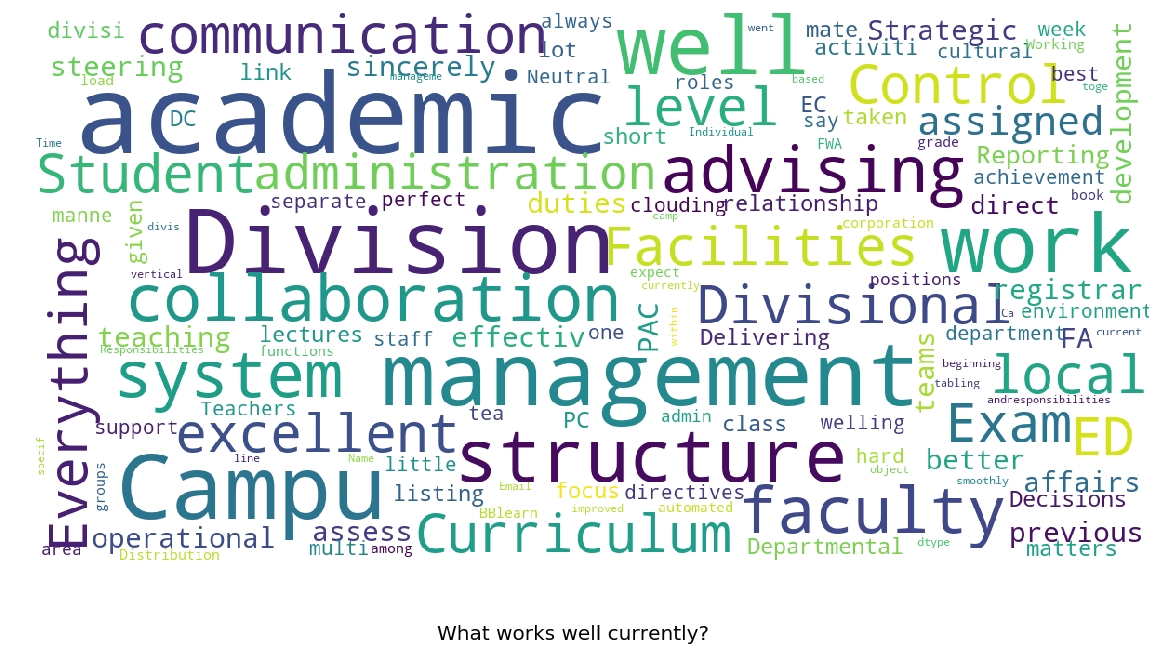

<FreqDist with 225 samples and 272 outcomes>


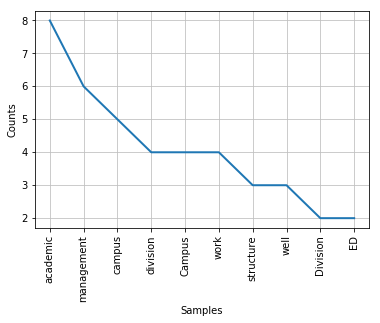

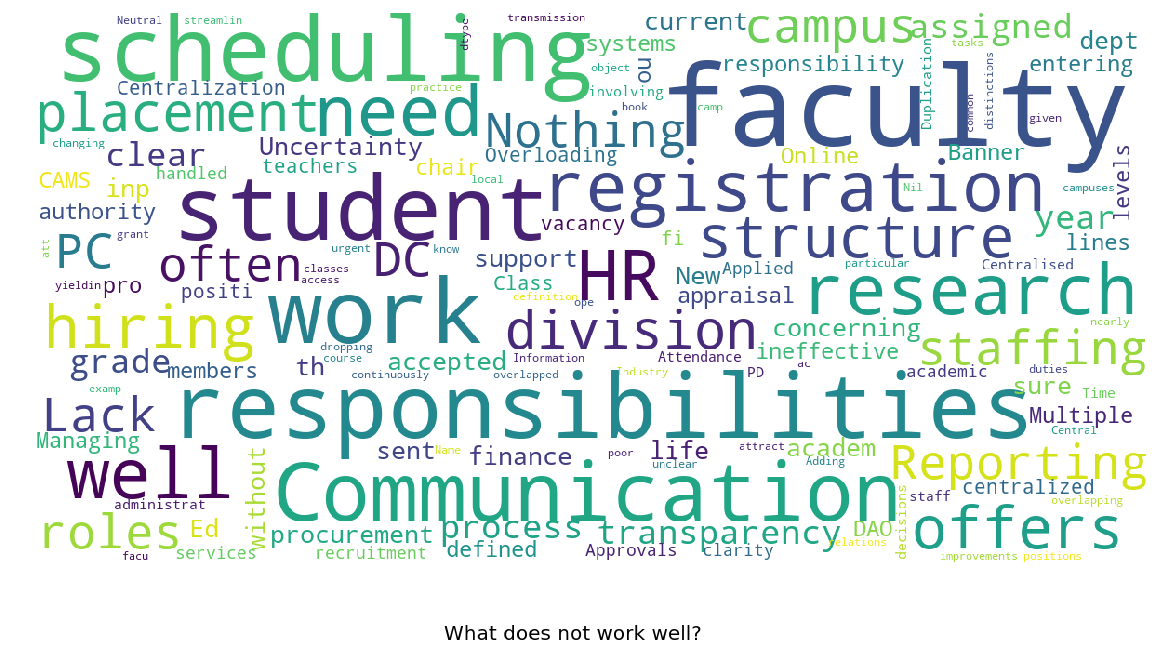

<FreqDist with 462 samples and 594 outcomes>


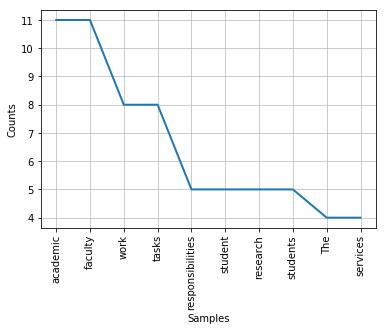

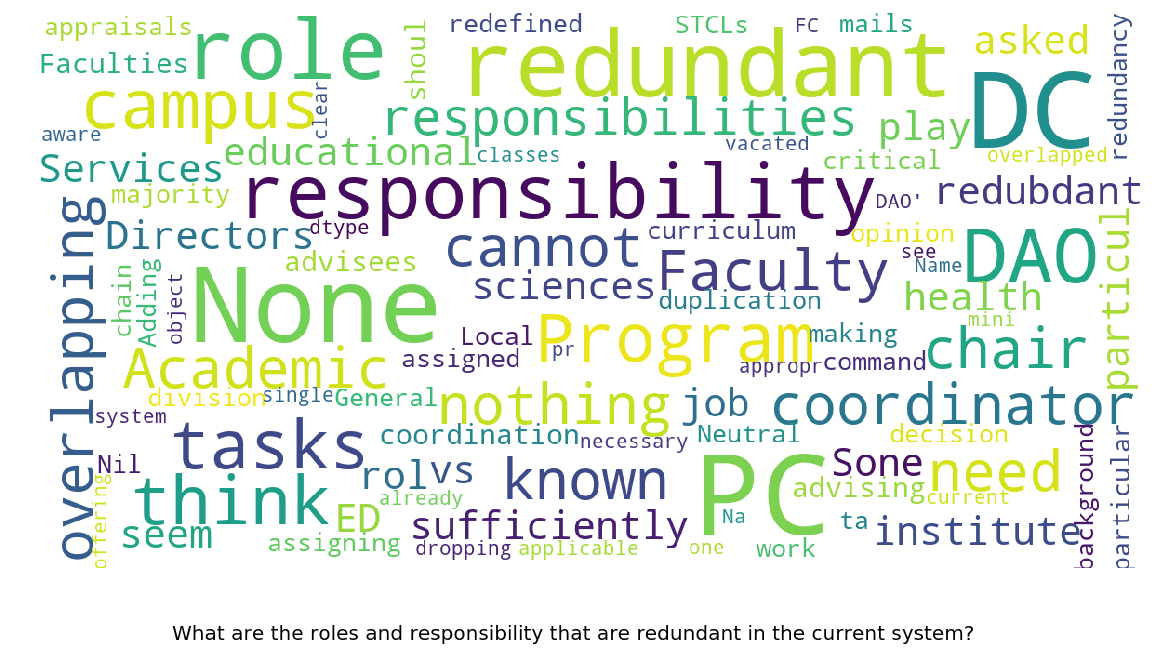

<FreqDist with 164 samples and 226 outcomes>


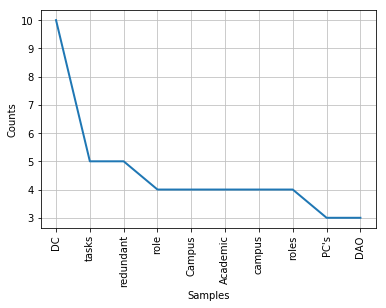

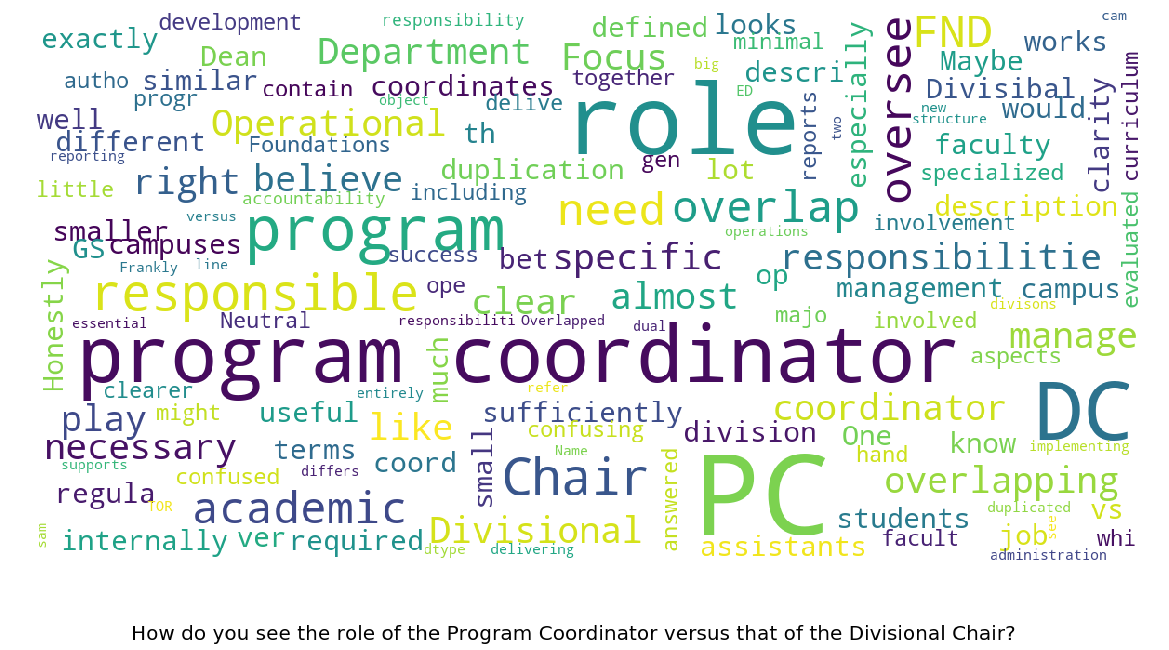

<FreqDist with 469 samples and 764 outcomes>


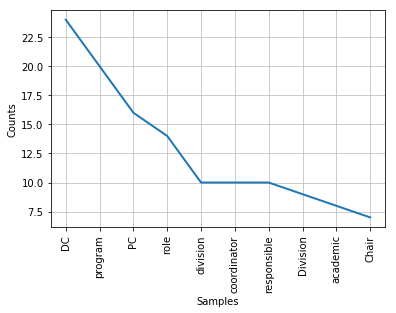

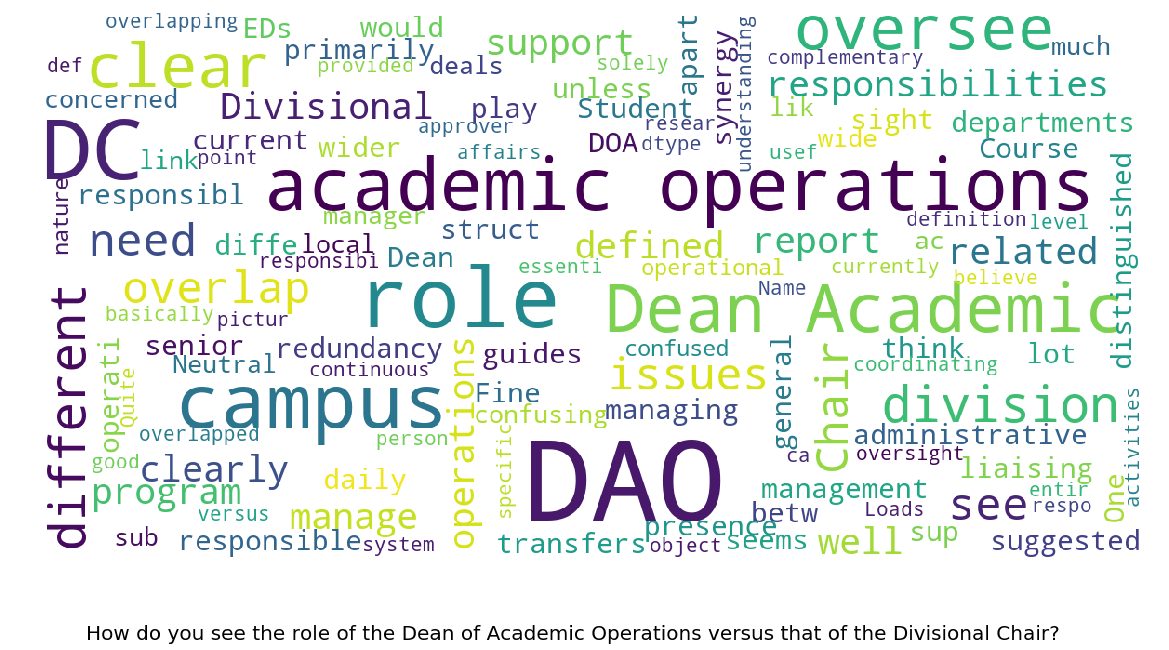

<FreqDist with 376 samples and 627 outcomes>


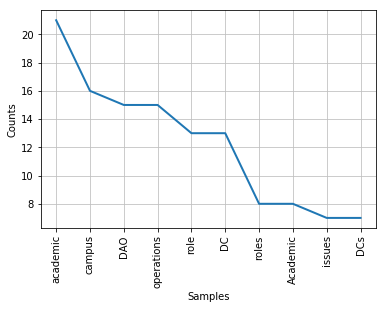

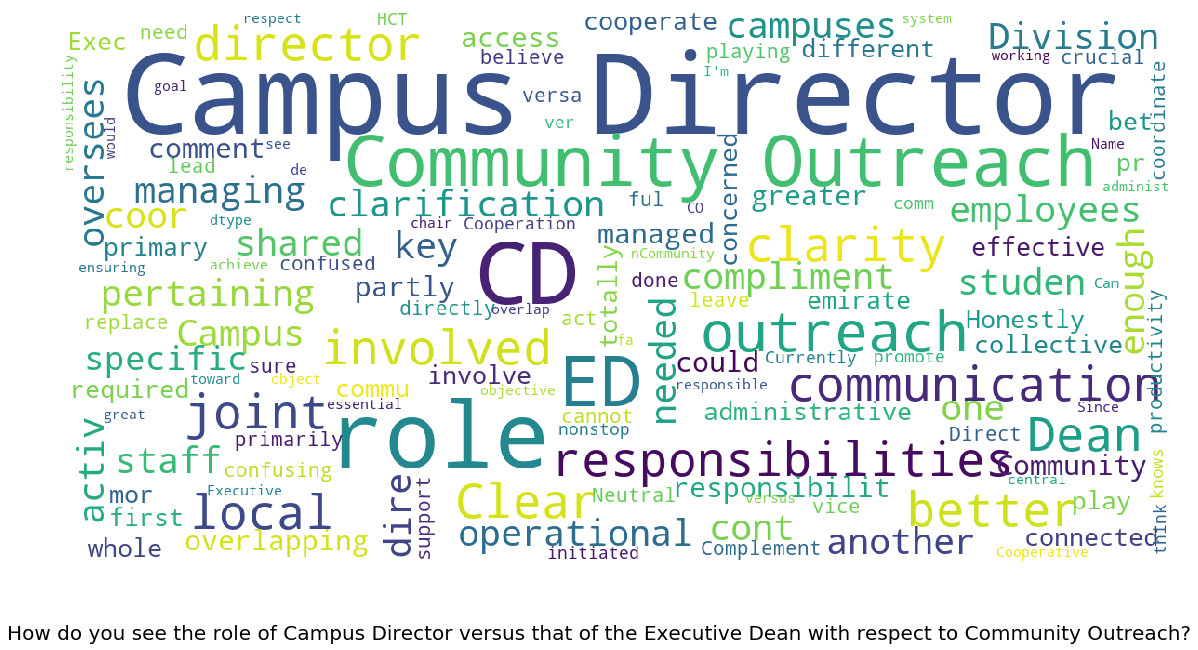

<FreqDist with 333 samples and 528 outcomes>


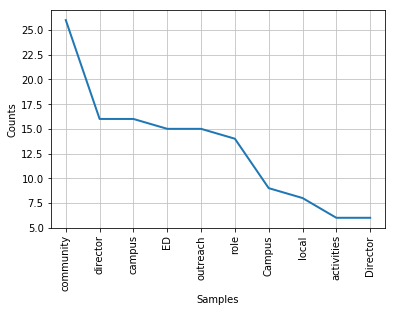

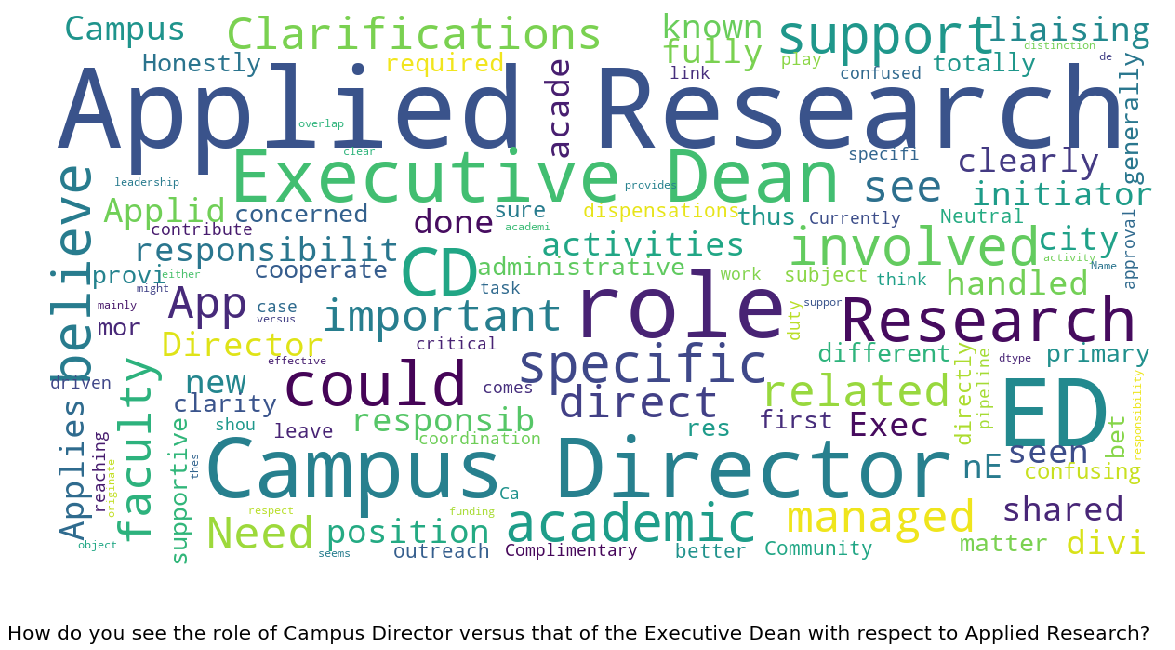

<FreqDist with 307 samples and 519 outcomes>


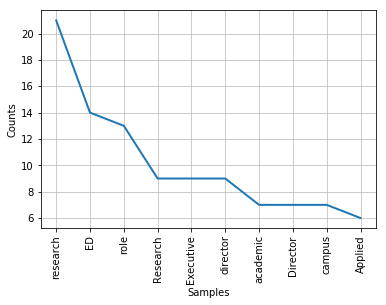

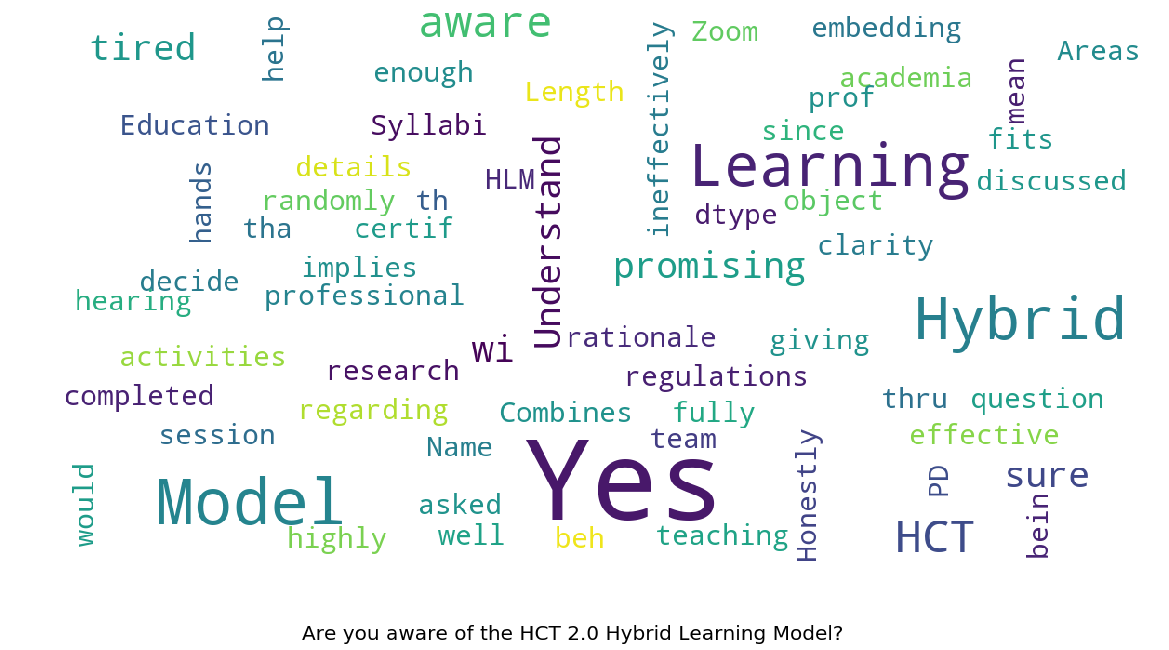

<FreqDist with 144 samples and 191 outcomes>


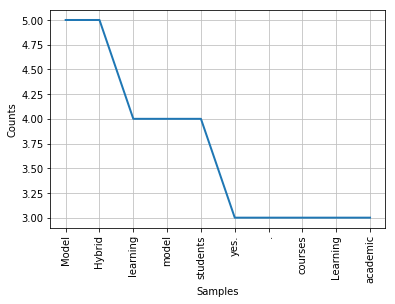

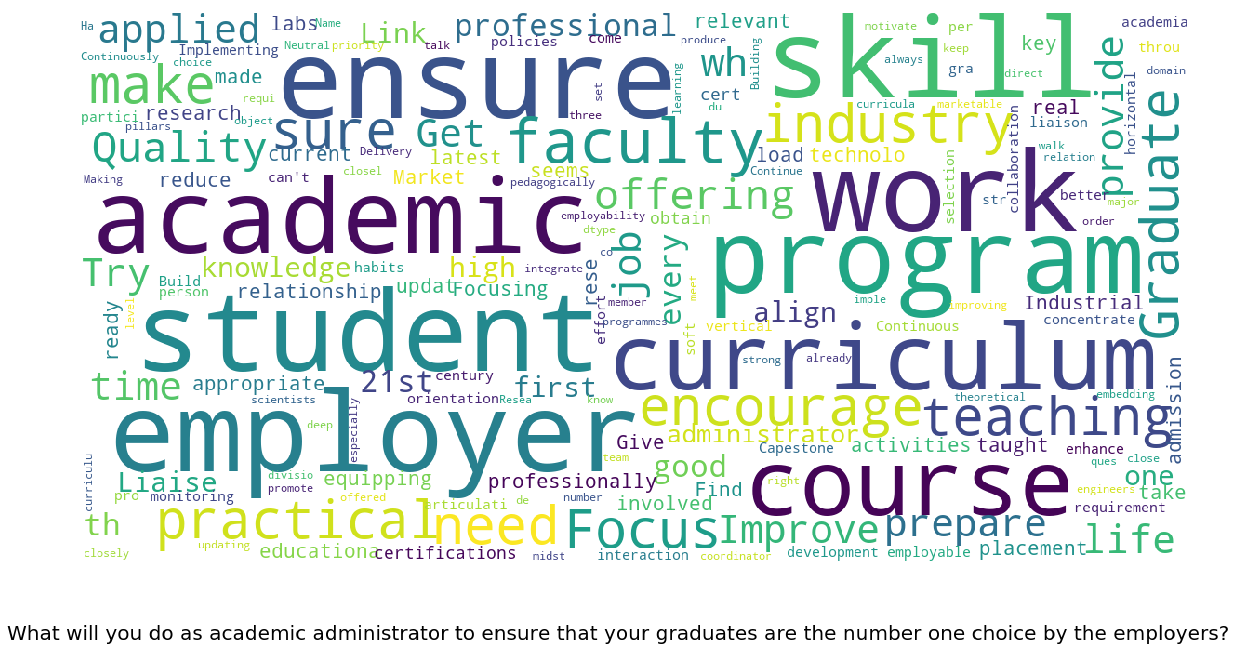

<FreqDist with 722 samples and 1137 outcomes>


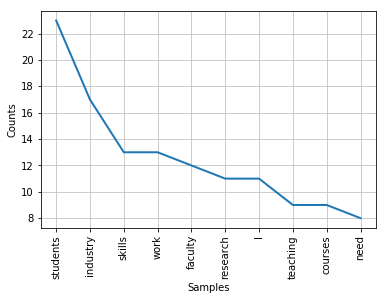

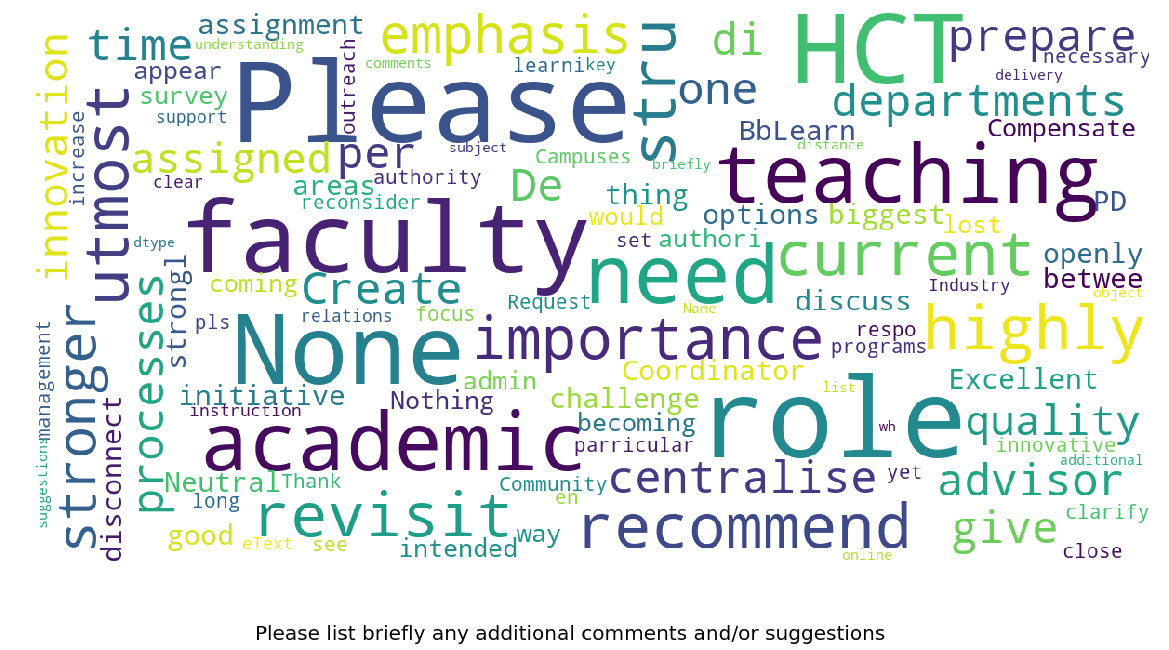

<FreqDist with 399 samples and 497 outcomes>


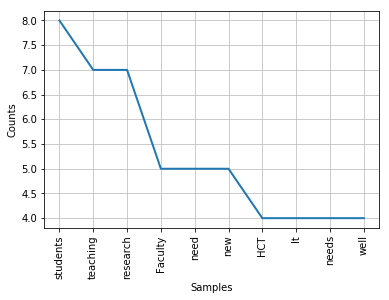

In [148]:
document = Document()
document.add_heading('Analysis of Campus Academic Management Survey', 0)
document.add_heading('Analysis of Open-ended questions', level=1)
document.add_paragraph('To get useful insight from the large text feedback, we have applied NLP and Machine Learning technology.', style='IntenseQuote')

p3col = part3.columns

#QSentiment()

for cl in p3col:
    
    document.add_heading(cl, level=1)
    TSentences(cl)
    show_wordcloud(part3[cl].dropna(),title=cl)
    myWordCount(cl)
    
    
document.save('demo.docx')

# Tokenize sentences and Lemmatizing Words